# Exploration and visualization

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import numpy.fft as fft
from scipy import stats
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import xgboost as xgb
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-whitegrid')

print(os.listdir("../input/safety/safety"))

['labels', 'data_dictionary.xlsx', 'features']


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
import random
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt

In [3]:
label_df = pd.read_csv("../input/safety/safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

In [4]:
len(label_df)

20018

In [5]:
label_df.head()

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


### Check for duplicate

In [6]:
label_df[label_df.duplicated(['bookingID'],keep=False)].sort_values(by='bookingID').head(10)

,bookingID,label
12602,13,1
12463,13,0
2351,154618822837,1
5295,154618822837,0
11215,223338299461,1
6212,223338299461,0
19936,395136991308,0
6121,395136991308,1
17623,403726925929,1
8472,403726925929,0


In [7]:
label_df = label_df.drop_duplicates(subset=['bookingID'], keep=False)

In [8]:
len(label_df)

19982

In [9]:
label_df.groupby('label', as_index=False).agg({'bookingID':'count'}).rename(columns={
    'bookingID':'count'
})

,label,count
0,0,14999
1,1,4983


In [10]:
%%time
path = "../input/safety/safety/features/"
files = os.listdir(path)
feature_df = None
for f in files:
    _ = pd.read_csv(os.path.join(path, f))
    if feature_df is None:
        feature_df = _
    else:
        feature_df = feature_df.append(_)

CPU times: user 33.5 s, sys: 12.6 s, total: 46.2 s
Wall time: 46.3 s


In [11]:
import gc
del _
gc.collect()

15

In [12]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16135561 entries, 0 to 1613554
Data columns (total 11 columns):
bookingID         int64
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
dtypes: float64(10), int64(1)
memory usage: 1.4 GB


In [13]:
feature_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1511828488290,11.0,122.300000,0.413000,9.334393,2.085948,0.034088,-0.000533,0.010120,497.0,15.750000
1,1039382085695,32.0,333.556213,0.160004,-2.685818,-10.589850,-0.010981,-0.119902,-0.001896,812.0,24.134781
2,369367187547,10.0,226.330978,-0.190659,-9.836038,-0.327783,-0.004936,0.051173,-0.007664,23.0,0.000000
3,146028888238,4.7,0.000000,1.544586,9.435682,4.084814,0.151146,-0.017209,0.005044,379.0,8.610183
4,1666447310852,10.0,226.624527,-0.836505,-9.970920,0.589771,0.073329,-0.223296,0.050306,132.0,15.620000


In [14]:
label_df = feature_df.groupby('bookingID')\
.agg({'Accuracy':'count'}, as_index=False)\
.rename(columns={'Accuracy':'count'})\
.merge(label_df, on='bookingID')\
.sort_values(by='count', ascending=False)\

In [15]:
label_df.head()

,bookingID,count,label
5744,438086664371,7561,1
16359,1374389534819,4499,1
446,34359738469,4302,1
13576,1108101562533,3925,1
9512,747324309632,3674,1


# One on One comparison

In [16]:
label_df[label_df['label']==1].head()

,bookingID,count,label
5744,438086664371,7561,1
16359,1374389534819,4499,1
446,34359738469,4302,1
13576,1108101562533,3925,1
9512,747324309632,3674,1


In [17]:
label_df[label_df['label']==0].head()

,bookingID,count,label
3035,223338299473,2355,0
11502,927712935958,2354,0
11202,901943132170,2189,0
13064,1073741824019,2175,0
14472,1185410973795,2115,0


In [18]:
temp_safe_df = feature_df[feature_df['bookingID'] == 223338299473].sort_values(by='second')
temp_unsafe_df = feature_df[feature_df['bookingID'] == 438086664371].sort_values(by='second')

In [19]:
temp_safe_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
237360,223338299473,12.0,243.547516,3.143549,-4.667172,-7.326672,0.311425,0.083308,0.083045,0.0,0.063314
640130,223338299473,12.0,215.545898,2.091412,-5.913855,-7.811768,-0.183991,0.156715,0.296485,1.0,0.063314
352592,223338299473,12.0,222.346436,1.355994,-5.248419,-8.031137,-0.073707,-0.138182,0.130820,2.0,0.063314
1239625,223338299473,8.0,231.678696,3.031396,-5.114584,-6.572412,0.140653,-0.069010,-0.258112,3.0,0.121282
472587,223338299473,8.0,234.715012,2.851505,-6.801053,-6.791333,-0.166590,0.036175,0.026017,4.0,0.121282


In [20]:
def plot(vals, title="", xlabel="", ylabel=''):
    fig = plt.figure(figsize=(14,3))
    ax = plt.subplot(111)
    for val in vals:
        label = ''
        c = 'b'
        if 'label' in val:
            label = val['label']
        if 'c' in val:
            c = val['c']
        if 'x' in val:
            x = val['x']
        else:
            x = [x for x in range(len(val['y']))]
        ax.plot(val['y'], label=label,c=c)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

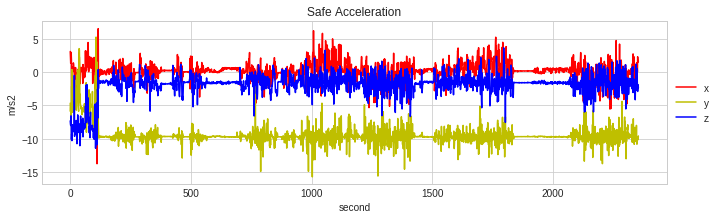

In [21]:
vals = [
        {'x':temp_safe_df['second'].values,'y':temp_safe_df['acceleration_x'].values, 'label':'x', 'c':'r'},
        {'x':temp_safe_df['second'].values,'y':temp_safe_df['acceleration_y'].values, 'label':'y', 'c':'y'},
        {'x':temp_safe_df['second'].values,'y':temp_safe_df['acceleration_z'].values, 'label':'z', 'c':'b'},
       ]
plot(vals, title='Safe Acceleration', xlabel='second', ylabel='m/s2')

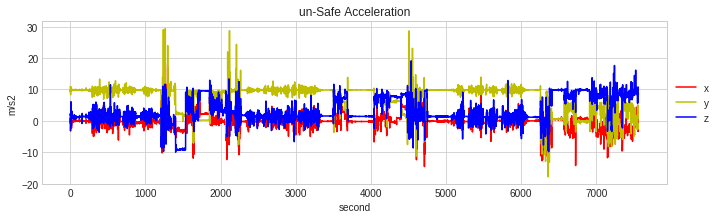

In [22]:
vals = [
        {'x':temp_unsafe_df['second'].values,'y':temp_unsafe_df['acceleration_x'].values, 'label':'x', 'c':'r'},
        {'x':temp_unsafe_df['second'].values,'y':temp_unsafe_df['acceleration_y'].values, 'label':'y', 'c':'y'},
        {'x':temp_unsafe_df['second'].values,'y':temp_unsafe_df['acceleration_z'].values, 'label':'z', 'c':'b'},
       ]
plot(vals, title='un-Safe Acceleration', xlabel='second', ylabel='m/s2')

In [23]:
temp_unsafe_df[['acceleration_x','acceleration_y','acceleration_z']].describe()

,acceleration_x,acceleration_y,acceleration_z
count,7561.000000,7561.000000,7561.000000
mean,-0.226412,7.368602,3.071358
std,2.265239,4.147914,3.826651
min,-14.592659,-17.878700,-10.007763
25%,-0.694319,5.918467,1.138443
50%,-0.143652,9.562442,1.593341
75%,0.535104,9.817424,6.345831
max,18.223467,29.346928,19.092562


In [24]:
temp_safe_df[['acceleration_x','acceleration_y','acceleration_z']].describe()

,acceleration_x,acceleration_y,acceleration_z
count,2355.000000,2355.000000,2355.000000
mean,0.133761,-9.457338,-1.863415
std,1.388432,1.553031,1.788245
min,-13.797400,-15.781296,-11.451178
25%,-0.271931,-9.928452,-2.153545
50%,0.202322,-9.711774,-1.582690
75%,0.637173,-9.380252,-1.145447
max,6.587216,5.312869,3.689804


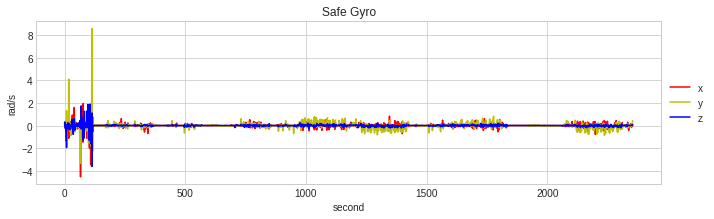

In [25]:
vals = [
        {'x':temp_safe_df['second'].values,'y':temp_safe_df['gyro_x'].values, 'label':'x', 'c':'r'},
        {'x':temp_safe_df['second'].values,'y':temp_safe_df['gyro_y'].values, 'label':'y', 'c':'y'},
        {'x':temp_safe_df['second'].values,'y':temp_safe_df['gyro_z'].values, 'label':'z', 'c':'b'},
       ]
plot(vals, title='Safe Gyro', xlabel='second', ylabel='rad/s')

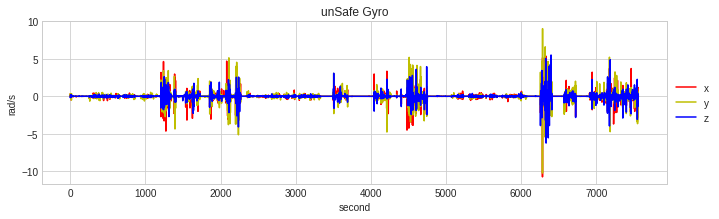

In [26]:
vals = [
        {'x':temp_unsafe_df['second'].values,'y':temp_unsafe_df['gyro_x'].values, 'label':'x', 'c':'r'},
        {'x':temp_unsafe_df['second'].values,'y':temp_unsafe_df['gyro_y'].values, 'label':'y', 'c':'y'},
        {'x':temp_unsafe_df['second'].values,'y':temp_unsafe_df['gyro_z'].values, 'label':'z', 'c':'b'},
       ]
plot(vals, title='unSafe Gyro', xlabel='second', ylabel='rad/s')

In [27]:
temp_safe_df[['gyro_x','gyro_y','gyro_z']].describe()

,gyro_x,gyro_y,gyro_z
count,2355.000000,2355.000000,2355.000000
mean,-0.008600,-0.009940,-0.005432
std,0.215787,0.307758,0.156574
min,-4.533381,-3.319976,-3.616390
25%,-0.033033,-0.055919,-0.016141
50%,-0.000047,-0.010964,0.000021
75%,0.024213,0.044955,0.014379
max,1.943711,8.552994,1.898375


In [28]:
temp_unsafe_df[['gyro_x','gyro_y','gyro_z']].describe()

,gyro_x,gyro_y,gyro_z
count,7561.000000,7561.000000,7561.000000
mean,-0.003321,-0.005692,-0.004200
std,0.449901,0.482948,0.365133
min,-10.737708,-10.228613,-6.233371
25%,-0.014294,-0.023702,-0.014396
50%,-0.000081,-0.000489,0.000098
75%,0.018713,0.018448,0.014820
max,5.336600,9.009367,5.498296


# Speed measured by GPS
* Looking at the plot between 2 speed of the safe and unsafe we can't really tell
* We'll see if acceleration derived could have some different

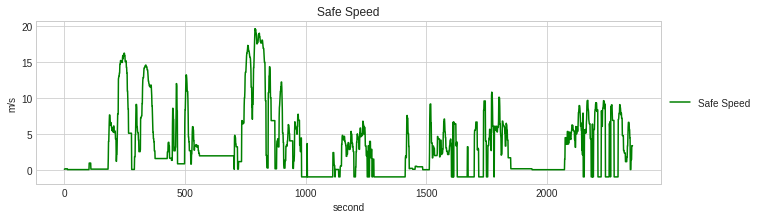

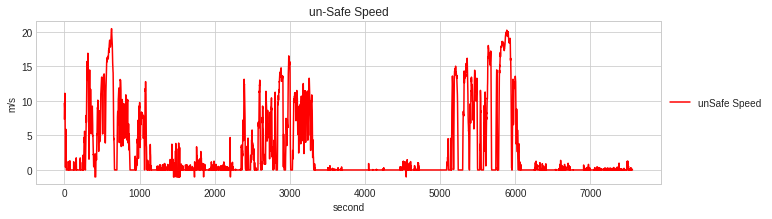

In [29]:
xlabel='second'
ylabel='m/s'
plot([{'x':temp_safe_df['second'].values,
       'y':temp_safe_df['Speed'].values, 'label':'Safe Speed', 'c':'g'}], 
     'Safe Speed', xlabel,ylabel)
plot([{'x':temp_unsafe_df['second'].values,
       'y':temp_unsafe_df['Speed'].values, 'label':'unSafe Speed', 'c':'r'}], 
     'un-Safe Speed', xlabel,ylabel)

### Deriving acceleration from velocity (speed)
\begin{equation}
a = \frac{{\Delta \upsilon }}{{\Delta t}} = \frac{{\upsilon_{f} - \upsilon_{i}}}{{t_{f}-t_{i}}}
\end{equation}
* After plotting the acceleration we start to see some pattern here, acceleration happened almost all the time for unsafe driving

In [30]:
temp_safe_df['acceration'] = (temp_safe_df['Speed']-temp_safe_df['Speed'].shift(1))/(temp_safe_df['second']-temp_safe_df['second'].shift(1))
temp_unsafe_df['acceration'] = (temp_unsafe_df['Speed']-temp_unsafe_df['Speed'].shift(1))/(temp_unsafe_df['second']-temp_unsafe_df['second'].shift(1))


### Signal to Noise Ratio


In [31]:
def signaltonoise(a, axis, ddof): 
    a = np.asanyarray(a) 
    m = a.mean(axis) 
    sd = a.std(axis = axis, ddof = ddof) 
    return np.where(sd == 0, 0, m / sd)

In [32]:
print("SNR for safe acceleration", signaltonoise(temp_safe_df['acceration'], axis=0, ddof=0))
print("SNR for un safe acceleration", signaltonoise(temp_unsafe_df['acceration'], axis=0, ddof=0))

SNR for safe acceleration nan
SNR for un safe acceleration nan


### Ratio of outlier

In [33]:
temp_safe_df = temp_safe_df.fillna(0)
temp_safe_df['z_acceleration'] = np.abs(stats.zscore(temp_safe_df['acceration']))

temp_unsafe_df = temp_unsafe_df.fillna(0)
temp_unsafe_df['z_acceleration'] = np.abs(stats.zscore(temp_unsafe_df['acceration']))

In [34]:
m = len(temp_safe_df[temp_safe_df['acceration'] != temp_safe_df['acceration'].median()])
print(len(temp_safe_df[temp_safe_df['z_acceleration'] > 3])/m)
m = len(temp_unsafe_df[temp_unsafe_df['acceration'] != temp_unsafe_df['acceration'].median()])
print(len(temp_unsafe_df[temp_unsafe_df['z_acceleration'] > 3])/m)

0.0946372239747634
0.07243867243867244


### Frequency Domain

[0.47770701 0.4866242  0.48832272]


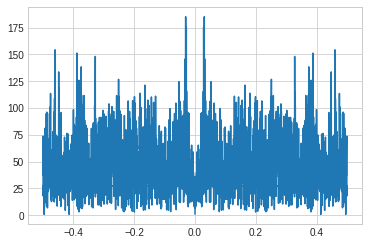

In [35]:
spectrum = fft.fft(temp_safe_df['acceration'] )
freq = fft.fftfreq(len(spectrum))
plt.plot(freq, abs(spectrum))

threshold = 0.5 * max(abs(spectrum))
mask = abs(spectrum) > threshold
peaks = freq[mask]

print(np.sort(peaks)[-3:])


[0.1264383  0.12657056 0.14164793]


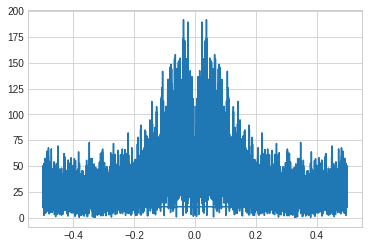

In [36]:
spectrum = fft.fft(temp_unsafe_df['acceration'] )
freq = fft.fftfreq(len(spectrum))
plt.plot(freq, abs(spectrum))

threshold = 0.5 * max(abs(spectrum))
mask = abs(spectrum) > threshold
peaks = freq[mask]

print(np.sort(peaks)[-3:])

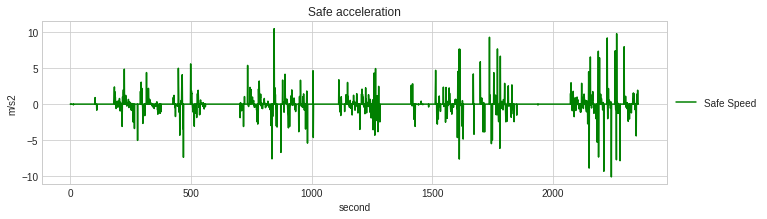

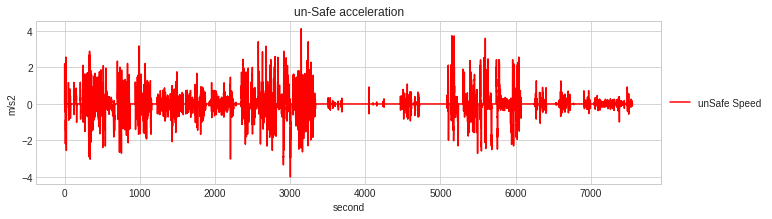

In [37]:
xlabel='second'
ylabel='m/s2'
plot([
    {'x':temp_safe_df['second'].values,
       'y':temp_safe_df['acceration'].values, 'label':'Safe Speed', 'c':'g'},
     ], 
     'Safe acceleration', xlabel,ylabel)
plot([{'x':temp_unsafe_df['second'].values,
       'y':temp_unsafe_df['acceration'].values, 'label':'unSafe Speed', 'c':'r'}], 
     'un-Safe acceleration', xlabel,ylabel)

### Distance
\begin{equation} x = \upsilon * \Delta t \end{equation}
* Approximate distance can be calculated from speed and second. Note that having lat and long will be more desirable to compute more accurate distance.

In [38]:
temp_safe_df['distance'] = (temp_safe_df['Speed'].shift(1))*(temp_safe_df['second']-temp_safe_df['second'].shift(1))
temp_unsafe_df['distance'] = (temp_unsafe_df['Speed'].shift(1))*(temp_unsafe_df['second']-temp_unsafe_df['second'].shift(1))


In [39]:
print("Travelled ", temp_unsafe_df['distance'].sum()/1000, "km in", temp_unsafe_df['second'].max()/60, "minutes")

Travelled  20.195559629914 km in 137.25 minutes


In [40]:
print("Travelled ", temp_safe_df['distance'].sum()/1000, "km in", temp_safe_df['second'].max()/60, "minutes")

Travelled  7.284550426052883 km in 39.65 minutes


# Bearing

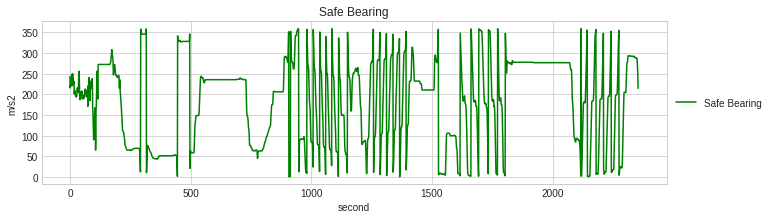

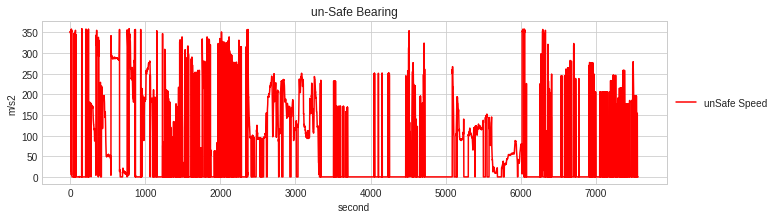

In [41]:
xlabel='second'
ylabel='m/s2'
plot([{'x':temp_safe_df['second'].values,
       'y':temp_safe_df['Bearing'].values, 'label':'Safe Bearing', 'c':'g'}], 
     'Safe Bearing', xlabel,ylabel)
plot([{'x':temp_unsafe_df['second'].values,
       'y':temp_unsafe_df['Bearing'].values, 'label':'unSafe Speed', 'c':'r'}], 
     'un-Safe Bearing', xlabel,ylabel)